In [ ]:
import nltk, csv, string, random, os, pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.classify import NaiveBayesClassifier, accuracy
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer, PorterStemmer
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
ENGLISH_STOPWORDS = stopwords.words('english')
PUNCTUATIONS = string.punctuation
LEMMATIZER = WordNetLemmatizer()
STEMMER = PorterStemmer()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Project-NLP/train-balanced-sarcasm-50k.csv")

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

,label,comment
0,0,I like the meta editing of photos
1,1,Any time you turn deadly weapons towards anoth...
2,1,Sup com 2 doesn't exist.
3,0,"Shoulda kept the bmw, definite downgrade."
4,1,Riot illuminate brain wash confirmed


In [ ]:
df['label'].value_counts()

label
1    25095
0    24905
Name: count, dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
def clean(tweet):
    #emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    tweet =  emoji_pattern.sub(r'', tweet)

    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)

    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)

    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)

    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)

    #Punctuations and special characters
    tweet = re.sub('[%s]' % re.escape(PUNCTUATIONS),'',tweet)

    tweet = tweet.lower()

    splits = tweet.split()
    splits = [word for word in splits if word not in set(ENGLISH_STOPWORDS)]
    tweet = ' '.join(splits)

    return tweet

In [ ]:
df['cleaned_text'] = df['comment'].apply((lambda x: clean(x)))
print("Cleaned")

Cleaned


In [ ]:
df.head()

,label,comment,cleaned_text
0,0,I like the meta editing of photos,like meta editing photos
1,1,Any time you turn deadly weapons towards anoth...,time turn deadly weapons towards another human...
2,1,Sup com 2 doesn't exist.,sup com 2 doesnt exist
3,0,"Shoulda kept the bmw, definite downgrade.",shoulda kept bmw definite downgrade
4,1,Riot illuminate brain wash confirmed,riot illuminate brain wash confirmed


In [ ]:
import gensim
from gensim import corpora, models

def training_word2vec_model(dataset_reviews):
    tokenized_words = [word_tokenize(review) for review in dataset_reviews]
    model = models.Word2Vec(tokenized_words, vector_size=1000, window=5, min_count=1)
    return model

def get_average_word2vec(review, model):
    tokenized_words = word_tokenize(review)
    word_vecs = []
    for tokenized_word in tokenized_words:
        if tokenized_word in model.wv:
            word_vecs.append(model.wv[tokenized_word])
    if len(word_vecs) == 0:
        return None
    return sum(word_vecs) / len(word_vecs)

train_data = df['cleaned_text'].to_list()
word2vecmodel = training_word2vec_model(train_data)
vectors = []
for review in train_data:
  avg_vector = get_average_word2vec(review, word2vecmodel)
  if avg_vector is not None:
    vectors.append(avg_vector)
  else:
    vectors.append([0] * word2vecmodel.vector_size)

In [ ]:
X = vectors
y = df['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    cm = confusion_matrix(predictions, test_y)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    return f1_score(predictions, test_y), accuracy_score(predictions, test_y)

XGBOOST CLASSIFIER


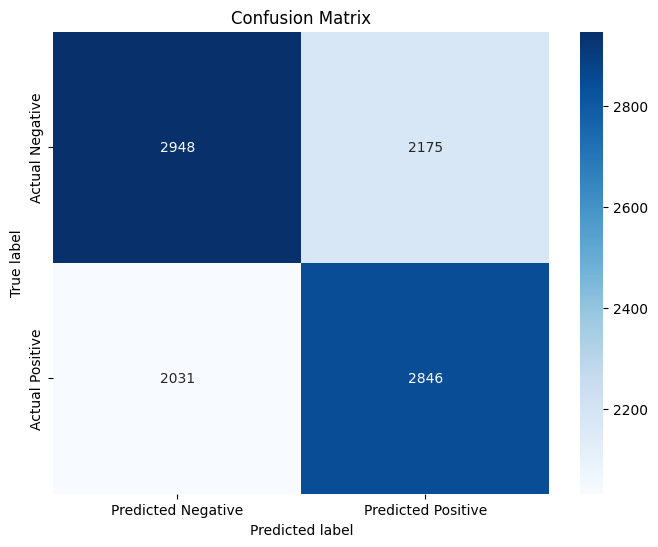

Accuracy: 0.5794
F1-Score: 0.5750656698322892


In [ ]:
print("XGBOOST CLASSIFIER")
print("========================================================")
f1, accuracy = train_model(XGBClassifier(), X_train, y_train, X_test, y_test)
print(f'Accuracy: {accuracy}')
print(f'F1-Score: {f1}')

K NEAREST NEIGHBORS


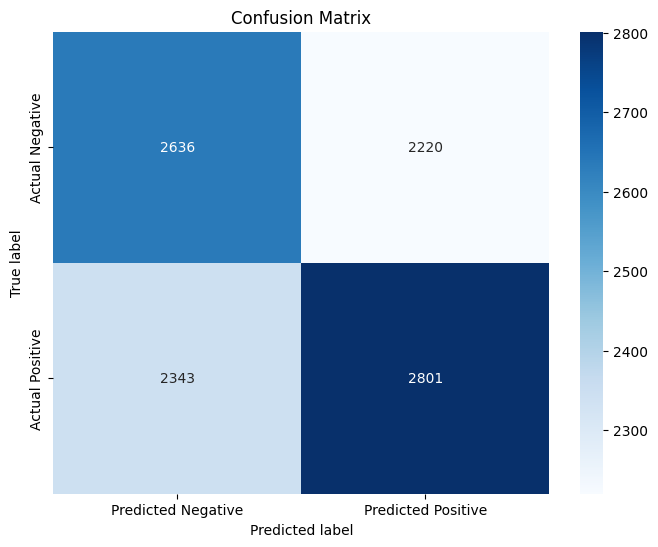

Accuracy: 0.5437
F1-Score: 0.5511067388096409


In [ ]:
print("K NEAREST NEIGHBORS")
print("========================================================")
f1, accuracy = train_model(KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2), X_train, y_train, X_test, y_test)
print(f'Accuracy: {accuracy}')
print(f'F1-Score: {f1}')

LOGISTIC REGRESSION


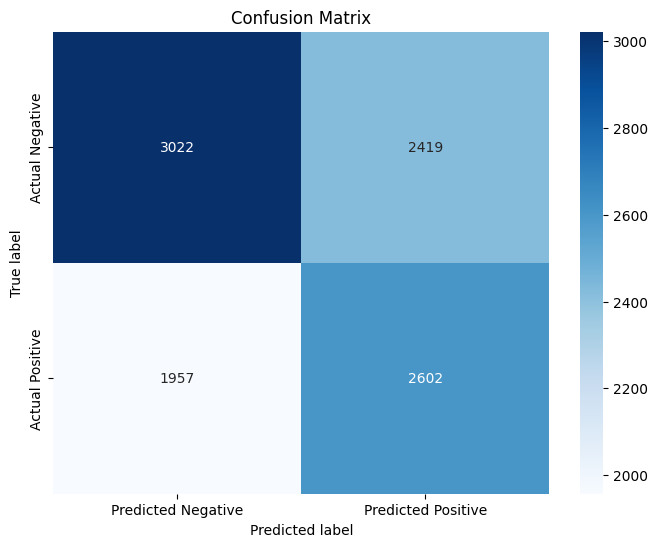

Accuracy: 0.5624
F1-Score: 0.5432150313152401


In [ ]:
print("LOGISTIC REGRESSION")
print("========================================================")
f1, accuracy = train_model(LogisticRegression(solver='lbfgs', max_iter=500), X_train, y_train, X_test, y_test)
print(f'Accuracy: {accuracy}')
print(f'F1-Score: {f1}')